In [4]:
import warnings
warnings.filterwarnings('ignore') # Wow nice.

In [5]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
# Datasets
from tensorflow.keras.datasets import cifar10


from alexnet import AlexNet
from vgg7 import SmallVGGNet

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg') # Non-interactive

import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split

import numpy as np
from imutils import paths, resize
import cv2
import os

## Network architecture

In [6]:
net = SmallVGGNet()
# net = AlexNet()
model = net.build(32, 32, num_classes=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
__________

## Loading, processing and splitting the dataset

In [7]:
print('# Loading CIFAR-10 dataset...')
(trainX, trainY), (testX, testY) = cifar10.load_data()
print('# CIFAR-10 dataset loaded!')

# Loading CIFAR-10 dataset...
# CIFAR-10 dataset loaded!


In [ ]:
target_size = 32

def preprocess(image):
    ''' Preprocess an image (resizeing, extracting patches/crops...) '''
    if image is not None:
        # Extract a random crop from the image
        image = extract_patches_2d(image, (target_size, target_size), max_patches=1)[0]
        # Transform image to array
        image = img_to_array(image, data_format=None)
        # Send back the image
        return image

trainX = [preprocess(image) for image in trainX]

print('Num training images:', len(trainX))

testX = [preprocess(image) for image in testX]

print('Num test images:', len(testX))

trainX = np.array(trainX)
testX = np.array(testX)

Num training images: 50000
Num test images: 10000


In [ ]:
# Scale the pixel intensity values to the range [0, 1]
def normalize(images):
    return images.astype('float') / 255.0

trainX = normalize(trainX)
testX = normalize(testX)

# Apply mean substraction
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

In [ ]:
# Convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)
print('After converting:', trainY)

# 1: [0 1 0 0 0 0 0 0 0 0]
# 4: [0 0 0 0 1 0 0 0 0 0]
# ...

After converting: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [ ]:
# Handle data augmentation
daug = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

## Train the network

In [ ]:
# Define the number of epochs (times dataset has been seen)
num_epochs = 100
# Define a custom polynomial learning rate scheduler

$$\alpha = \alpha_{0} * (1 - e / e_{\max})^{^{p}}$$

In [ ]:
init_lr = 5e-2

def polynomial_decay(epoch):
    max_epochs = num_epochs
    base_lr = init_lr
    power = 1.0
    
    return base_lr * (1 - (epoch / float(max_epochs))) ** power

In [ ]:
# Set the optimizer (here using Stochastic Gradient Descent with a learning rate of X, epochs-based decay and a momentum)
# Decay slowly reduces the learning rate to reduce overfitting and get higher classification accc
sgd_opt = SGD(lr=init_lr, momentum=0.9)
# adam_opt = Adam(lr=1e-3)
# Compile the model
print('# Compiling the model...')
model.compile(loss='categorical_crossentropy', optimizer=sgd_opt, metrics=['accuracy'])
# Train the network!
print('# Training the network...')
h = model.fit_generator(
    daug.flow(trainX, trainY, batch_size=256), validation_data=(testX, testY),
    epochs=num_epochs, steps_per_epoch=len(trainX) // 256,
    callbacks=[LearningRateScheduler(polynomial_decay)], verbose=1
)

# Compiling the model...
# Training the network...
Epoch 1/100
195/195 [==============================] - 30s 155ms/step - loss: 2.0204 - acc: 0.3551 - val_loss: 2.2916 - val_acc: 0.2550
Epoch 2/100
195/195 [==============================] - 26s 135ms/step - loss: 1.6461 - acc: 0.4574 - val_loss: 1.5217 - val_acc: 0.4748
Epoch 3/100
195/195 [==============================] - 27s 136ms/step - loss: 1.4958 - acc: 0.5020 - val_loss: 1.4899 - val_acc: 0.4673
Epoch 4/100
195/195 [==============================] - 26s 134ms/step - loss: 1.3716 - acc: 0.5343 - val_loss: 1.3450 - val_acc: 0.5290
Epoch 5/100
195/195 [==============================] - 26s 134ms/step - loss: 1.2579 - acc: 0.5714 - val_loss: 0.9997 - val_acc: 0.6461
Epoch 6/100
195/195 [==============================] - 26s 136ms/step - loss: 1.1482 - acc: 0.6074 - val_loss: 0.9101 - val_acc: 0.6848
Epoch 7/100
195/195 [==============================] - 26s 135ms/step - loss: 1.0937 - acc: 0.6286 - val_loss: 0.9799 - val_acc: 0.66

## Evalute the network

In [ ]:
# Set labels names for easier reading
label_names = ['Airplane', 'Automobile', 'Bird',
              'Cat', 'Deer', 'Dog', 'Frog',
              'Horse', 'Ship', 'Truck']

# Evalutate the network
print('# Trained the network! Evaluating...')
preds = model.predict(testX, batch_size=256)
print(classification_report(testY.argmax(axis=1),
preds.argmax(axis=1), target_names=label_names))

print('Predictions (max):', preds)

# Trained the network! Evaluating...
              precision    recall  f1-score   support

    Airplane       0.89      0.85      0.87      1000
  Automobile       0.90      0.95      0.93      1000
        Bird       0.83      0.77      0.80      1000
         Cat       0.83      0.65      0.73      1000
        Deer       0.84      0.82      0.83      1000
         Dog       0.85      0.75      0.80      1000
        Frog       0.70      0.96      0.81      1000
       Horse       0.89      0.89      0.89      1000
        Ship       0.93      0.92      0.92      1000
       Truck       0.87      0.94      0.90      1000

   micro avg       0.85      0.85      0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Predictions (max): [[8.1684470e-07 1.2683062e-05 1.6103597e-05 ... 3.2290185e-07
  3.4115951e-06 2.1468961e-06]
 [6.5632079e-08 1.2283932e-04 1.7434585e-11 ... 5.6176669e-15
  9.9987662e-01 5.2539406e-07]

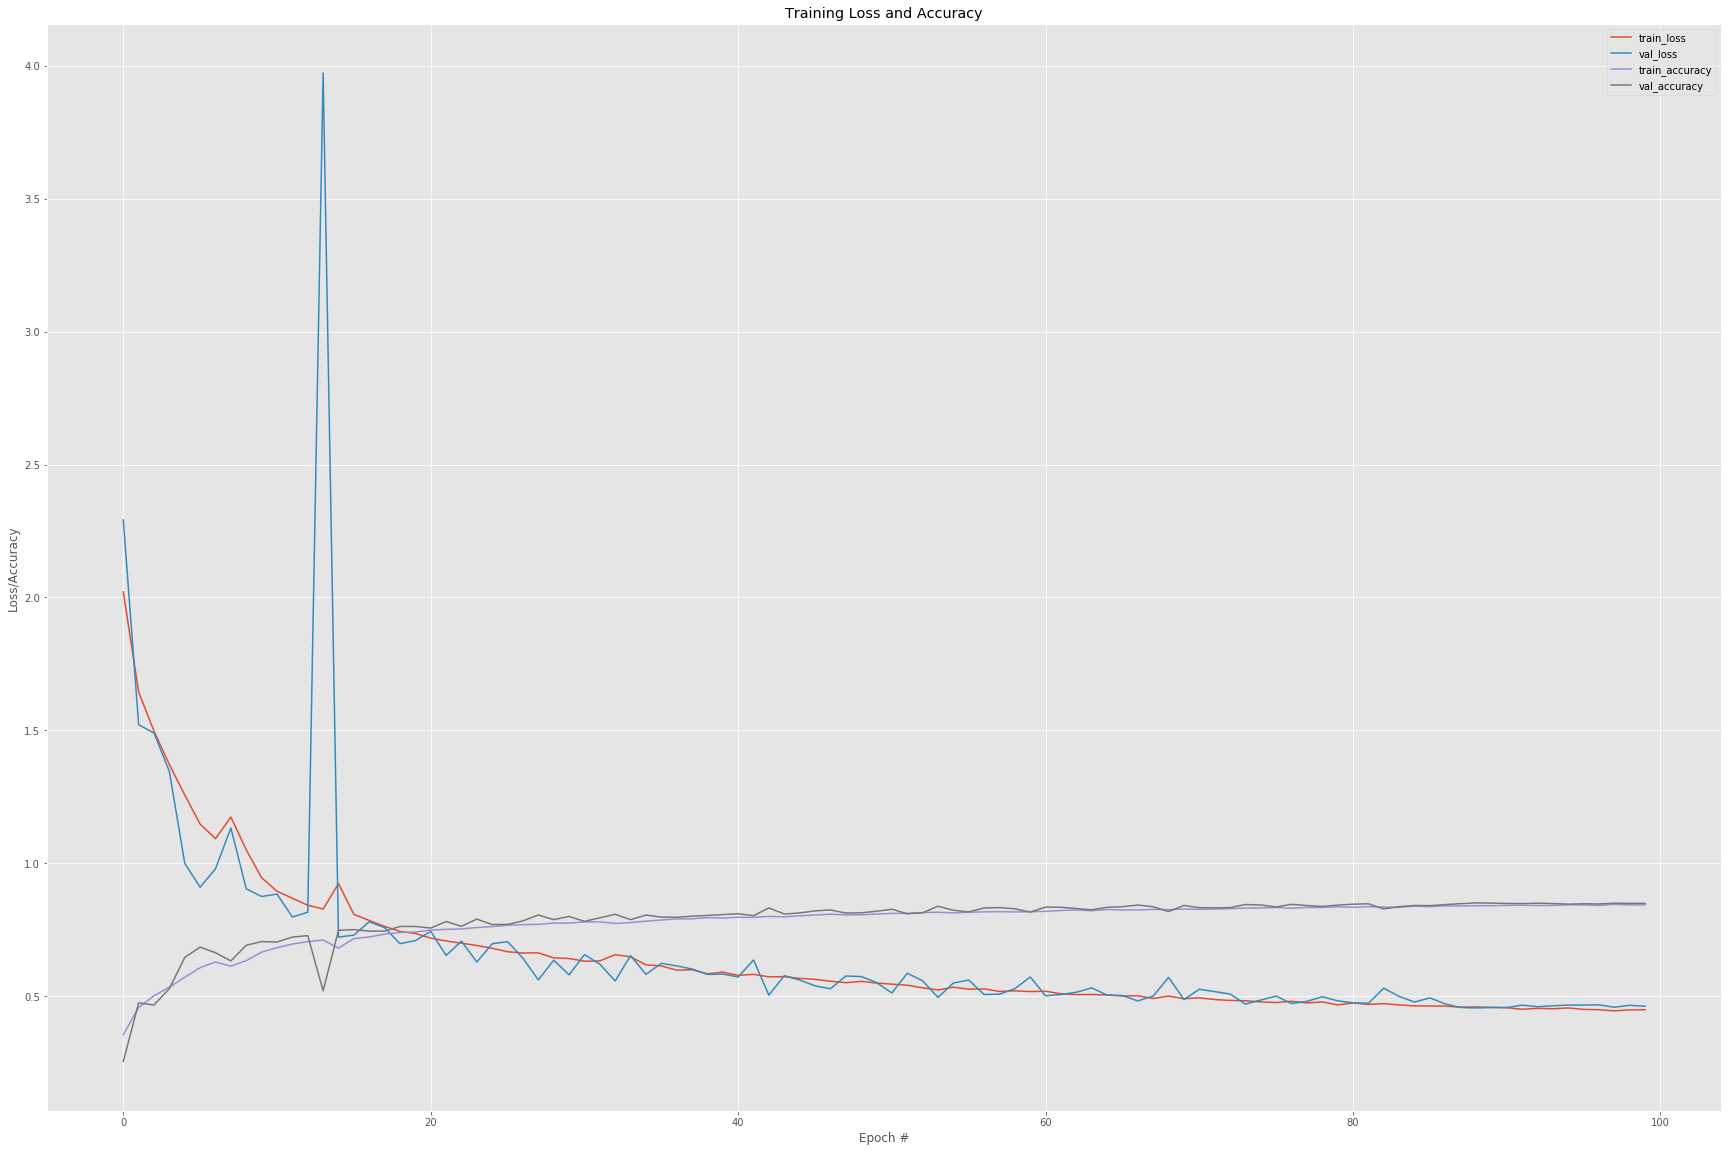

In [ ]:
%matplotlib inline
# Plot history to check for overfitting
plt.style.use('ggplot')
plt.figure(figsize=(30, 20))
plt.plot(np.arange(0, num_epochs), h.history['loss'], label='train_loss')
plt.plot(np.arange(0, num_epochs), h.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, num_epochs), h.history['acc'], label='train_accuracy')
plt.plot(np.arange(0, num_epochs), h.history['val_acc'], label='val_accuracy')

plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend()

plt.show()

# Experiment notes

- [x] Used a custom polynomial learning rate scheduler over 100 epochs
- [x] Extracted patches from images and applied data augmentation
- [x] Removed Nesterov acceleration
- [x] Added one more CONV => RELU => BN layers set

- Initial learning rate of 5e-3: Model was slightly underfitting, could train longer
- Updated initial lr by 6e-3: Model started to slightly overfit after 80 epochs